In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from tqdm.notebook import tqdm

2023-06-15 17:08:01.103740: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-15 17:08:01.128714: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 17:08:01.816169: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [3]:
from datasets import load_dataset

dataset = load_dataset("amazon_us_reviews", "Apparel_v1_00")
train_data = dataset['train']

# Limit the dataset to the first 100,000 rows
train_data = train_data.select(range(100000))

df = train_data.to_pandas()  # Convert the dataset to a Pandas DataFrame
df = df[['customer_id', 'review_headline', 'review_body', 'star_rating']]  # Select specific columns
df.columns = ['customer_id', 'review_headline', 'review_body', 'star_rating']  # Rename the selected columns
df.set_index('customer_id', inplace=True)
df.head()  # Display the first few rows of the DataFrame

Using the latest cached version of the module from /home/z123010/.cache/huggingface/modules/datasets_modules/datasets/amazon_us_reviews/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563 (last modified on Tue May 23 19:43:32 2023) since it couldn't be found locally at amazon_us_reviews., or remotely on the Hugging Face Hub.
Found cached dataset amazon_us_reviews (/home/z123010/.cache/huggingface/datasets/amazon_us_reviews/Apparel_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)


  0%|          | 0/1 [00:00<?, ?it/s]

,review_headline,review_body,star_rating
customer_id,,,
32158956,★ THESE REALLY DO WORK GREAT WITH SOME TWEAKING ★,"These Really Do Work Great, But You Do Need To...",4
2714559,Favorite for winter. Very warm!,I love this dress. Absolute favorite for winte...,5
12608825,Great Socks for the money.,"Nice socks, great colors, just enough support ...",5
25482800,Slick hat!,"I bought this for my husband and WOW, this is ...",5
9310286,I would do it again!,Perfect dress and the customer service was awe...,5


In [4]:
df.star_rating.value_counts()

star_rating
5    53374
4    17763
1    11741
3    10431
2     6691
Name: count, dtype: int64

In [5]:
df['sentiment'] = df['star_rating'].map({5: 'good', 4: 'good', 3: 'neutral', 2: 'bad', 1: 'bad'})

In [6]:
df['sentiment'].value_counts()

sentiment
good       71137
bad        18432
neutral    10431
Name: count, dtype: int64

In [7]:
possible_labels = df.sentiment.unique() #Get unique category labels from the DataFrame column 'category'

In [8]:
label_dict = {} #Create a dictionary to map each possible label to a unique index
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [9]:
label_dict

{'good': 0, 'neutral': 1, 'bad': 2}

In [10]:
df['label'] = df.sentiment.replace(label_dict)
df.head(10)

,review_headline,review_body,star_rating,sentiment,label
customer_id,,,,,
32158956,★ THESE REALLY DO WORK GREAT WITH SOME TWEAKING ★,"These Really Do Work Great, But You Do Need To...",4,good,0
2714559,Favorite for winter. Very warm!,I love this dress. Absolute favorite for winte...,5,good,0
12608825,Great Socks for the money.,"Nice socks, great colors, just enough support ...",5,good,0
25482800,Slick hat!,"I bought this for my husband and WOW, this is ...",5,good,0
9310286,I would do it again!,Perfect dress and the customer service was awe...,5,good,0
26631939,Five Stars,Excellent for my 6 feet skinny 15 years old boy.,5,good,0
48785098,Love it!,Raw is the only way to go! Absolutely love thi...,5,good,0
39548589,Three Stars,A bit large.,4,good,0
29355866,Five Stars,Great fit!,5,good,0


In [11]:
df['label'] = df.sentiment.replace(label_dict)
df.head(10)

,review_headline,review_body,star_rating,sentiment,label
customer_id,,,,,
32158956,★ THESE REALLY DO WORK GREAT WITH SOME TWEAKING ★,"These Really Do Work Great, But You Do Need To...",4,good,0
2714559,Favorite for winter. Very warm!,I love this dress. Absolute favorite for winte...,5,good,0
12608825,Great Socks for the money.,"Nice socks, great colors, just enough support ...",5,good,0
25482800,Slick hat!,"I bought this for my husband and WOW, this is ...",5,good,0
9310286,I would do it again!,Perfect dress and the customer service was awe...,5,good,0
26631939,Five Stars,Excellent for my 6 feet skinny 15 years old boy.,5,good,0
48785098,Love it!,Raw is the only way to go! Absolutely love thi...,5,good,0
39548589,Three Stars,A bit large.,4,good,0
29355866,Five Stars,Great fit!,5,good,0


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
#Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.15,
    random_state=17,
    stratify=df.label.values
)

In [14]:
df['data_type'] = ['not_set']*df.shape[0] #Set a new column 'data_type' for later data split

In [15]:
df.head()

,review_headline,review_body,star_rating,sentiment,label,data_type
customer_id,,,,,,
32158956,★ THESE REALLY DO WORK GREAT WITH SOME TWEAKING ★,"These Really Do Work Great, But You Do Need To...",4,good,0,not_set
2714559,Favorite for winter. Very warm!,I love this dress. Absolute favorite for winte...,5,good,0,not_set
12608825,Great Socks for the money.,"Nice socks, great colors, just enough support ...",5,good,0,not_set
25482800,Slick hat!,"I bought this for my husband and WOW, this is ...",5,good,0,not_set
9310286,I would do it again!,Perfect dress and the customer service was awe...,5,good,0,not_set


In [16]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [17]:
#Set the 'data_type' column of the dataframe for training and validation data
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [18]:
df.groupby(['star_rating', 'label', 'data_type']).count()

review_headline  review_body  sentiment
star_rating label data_type                                         
1           2     train                 9581         9581       9581
                  val                   2160         2160       2160
2           2     train                 5463         5463       5463
                  val                   1228         1228       1228
3           1     train                 8439         8439       8439
                  val                   1992         1992       1992
4           0     train                14202        14202      14202
                  val                   3561         3561       3561
5           0     train                41279        41279      41279
                  val                  12095        12095      12095

In [19]:
# Load BERT tokenizer
pretrained_path = 'bert-base-uncased'  # Replace with the path to the pretrained BERT model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

In [20]:
encoded_data_train_headline = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_headline.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_train_body = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_body.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_train_headline = encoded_data_train_headline['input_ids']
attention_masks_train_headline = encoded_data_train_headline['attention_mask']

input_ids_train_body = encoded_data_train_body['input_ids']
attention_masks_train_body = encoded_data_train_body['attention_mask']

input_ids_train = torch.cat((input_ids_train_headline, input_ids_train_body), dim=1)
attention_masks_train = torch.cat((attention_masks_train_headline, attention_masks_train_body), dim=1)

labels_train = torch.tensor(df[df.data_type=='train'].label.values)


encoded_data_val_headline = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_headline.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val_body = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_body.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_val_headline = encoded_data_val_headline['input_ids']
attention_masks_val_headline = encoded_data_val_headline['attention_mask']

input_ids_val_body = encoded_data_val_body['input_ids']
attention_masks_val_body = encoded_data_val_body['attention_mask']

input_ids_val = torch.cat((input_ids_val_headline, input_ids_val_body), dim=1)
attention_masks_val = torch.cat((attention_masks_val_headline, attention_masks_val_body), dim=1)

labels_val = torch.tensor(df[df.data_type=='val'].label.values)

In [21]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [22]:
len(dataset_train)

78964

In [23]:
len(dataset_val)

21036

In [24]:
# Set parameters
SEQ_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LR = 2e-5

In [25]:
num_classes = 6

class SentimentModel(nn.Module):
    def __init__(self):
        super(SentimentModel, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_path)
        self.dropout = nn.Dropout(0.2)
        self.lstm = nn.LSTM(self.bert.config.hidden_size, 256, batch_first=True)
        self.fc = nn.Linear(256, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)[0]
        outputs = self.dropout(outputs)
        outputs, _ = self.lstm(outputs)
        outputs = self.fc(outputs[:, -1, :])
        outputs = self.softmax(outputs)
        
        if labels is not None:
            loss = nn.CrossEntropyLoss()(outputs.view(-1, num_classes), labels.view(-1))
            return loss, outputs, labels
        else:
            return outputs

In [26]:
# Create model instance
model = SentimentModel()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [28]:
from transformers import TrainingArguments, Trainer, logging
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    **default_args,
)

In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
)


In [30]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Set the batch size and create data loaders for training and validation sets

batch_size = 8 #32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

In [31]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

epochs = 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

/home/z123010/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
import numpy as np

In [33]:
from sklearn.metrics import f1_score #F1 score is a measure of a model's accuracy, combining both precision and recall, used to evaluate binary classification models.

In [34]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten() #This line finds the index with the highest probability in each prediction, effectively giving the predicted class for each input.
    labels_flat = labels.flatten()  #This line flattens the labels array into a 1D vector, as required by the f1_score function.
    return f1_score(labels_flat, preds_flat, average='weighted') #This line computes the F1 score using the true labels and the predicted labels, with the weighted averaging scheme. The result is returned.

In [35]:
def accuracy_per_class(preds, labels):
    # Create a dictionary with keys and values reversed for easy lookup.
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Get the predicted labels and flatten them.
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Get the actual labels and flatten them.
    labels_flat = labels.flatten()

    # Iterate over the unique labels in the actual labels.
    for label in np.unique(labels_flat):
        # Get the predicted labels for this class.
        y_preds = preds_flat[labels_flat==label]
        
        # Get the actual labels for this class.
        y_true = labels_flat[labels_flat==label]
        
        # Print the class name, accuracy numerator and denominator.
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [36]:
import random

seed_val = 17
random.seed(seed_val) #sets the seed value for the Python built-in pseudo-random generator.
np.random.seed(seed_val) #sets the seed value for the NumPy pseudo-random number generator.
torch.manual_seed(seed_val) #sets the seed value for the random number generator in PyTorch on the CPU.
torch.cuda.manual_seed_all(seed_val) #sets the seed value for the random number generator in PyTorch on the GPU.

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [38]:
#This code evaluates the performance of a trained model on a validation dataset by computing its loss and predictions for each batch in the dataset.
def evaluate(dataloader_val):

    model.eval() # setting the model to evaluation mode to disable dropout and other regularization techniques that are useful during training but not during evaluation.
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
    
        batch = tuple(b.to(device) for b in batch) # moving the input batch to the GPU for faster computation.
   
        #  creating a dictionary of inputs that will be passed to the model. The input IDs and attention mask are for the BERT model, and the labels are the true labels for each input.
        inputs = {'input_ids':  	batch[0],
                'attention_mask': batch[1],
                'labels':     	batch[2],
                } 

        with torch.no_grad():   
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
       	 
    return loss_val_avg, predictions, true_vals




In [39]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [40]:
import time
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.exceptions import UndefinedMetricWarning
import matplotlib.pyplot as plt
from tabulate import tabulate
def train_model(trainer, dataloader_train, dataloader_val, epochs):
    total_training_time = 0
    
    training_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    precision_list = []
    f1_score_list = []
    
    previous_results = None  # Store previous epoch results
    
    for epoch in tqdm(range(1, epochs + 1)):
        start_time = time.time()
    
        model.train()
        loss_train_total = 0
    
        progress_bar = tqdm(dataloader_train,
                            desc='Epoch {:1d}'.format(epoch),
                            leave=False,
                            disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }
            output, predictions, true_vals = model(**inputs)
            loss = output
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
        end_time = time.time()
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time
    
        torch.save(model.state_dict(), f'Models/finetuned_bert_lstm_ft_epoch{epoch}.model')
    
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
    
        val_loss, predictions, true_vals = evaluate(dataloader_val)
    
        # Convert predictions to discrete labels
        predictions = np.argmax(predictions, axis=1)
    
        val_f1 = f1_score(true_vals, predictions, average='weighted')
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
    
        val_accuracy = accuracy_score(true_vals, predictions)
        val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)
    
        # Compute and store metrics
        training_loss_list.append(loss_train_avg)
        validation_loss_list.append(val_loss)
        f1_score_list.append(val_f1)
        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
    
        # Check if there are previous results to compare with
        if previous_results is not None:
            if loss_train_avg > previous_results['loss_train_avg']:
                percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
            if loss_train_avg < previous_results['loss_train_avg']:
                percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
            if val_loss > previous_results['val_loss']:
                percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
            if val_loss < previous_results['val_loss']:
                percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
            if val_f1 < previous_results['val_f1']:
                percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
            if val_f1 > previous_results['val_f1']:
                percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')
    
        # Store current results as previous results for the next epoch
        previous_results = {
            'loss_train_avg': loss_train_avg,
            'val_loss': val_loss,
            'val_f1': val_f1
        }
    
    total_time_minutes = total_training_time / 60
    tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')
    
    final_accuracy = accuracy_list[-1]
    final_precision = precision_list[-1]
    tqdm.write(f'Final Accuracy: {final_accuracy}')
    tqdm.write(f'Final Precision: {final_precision}')
    
    # Create a single subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot training loss
    ax.plot(range(1, epochs + 1), training_loss_list, label='Training Loss')
    
    # Plot validation loss
    ax.plot(range(1, epochs + 1), validation_loss_list, label='Validation Loss')
    
    # Plot F1-score
    ax.plot(range(1, epochs + 1), f1_score_list, label='F1 Score')
    
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.set_title('Training Loss, Validation Loss, and F1 Score')
    
    # Set legend
    ax.legend()
    
    # Show the combined plot
    plt.show()

    
    # Create the metrics table
    metrics_table = [
        ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
    ]
    previous_results = None
    for epoch in range(1, epochs + 1):
        row = [
            epoch,
            training_loss_list[epoch - 1],
            validation_loss_list[epoch - 1],
            f1_score_list[epoch - 1],
            accuracy_list[epoch - 1],
            precision_list[epoch - 1]
        ]
    
        # Compare with previous epoch results
        if previous_results is not None:
            if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
                row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
            if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
                row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
            if validation_loss_list[epoch - 1] < previous_results['val_loss']:
                row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
            if validation_loss_list[epoch - 1] > previous_results['val_loss']:
                row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
            if f1_score_list[epoch - 1] > previous_results['val_f1']:
                row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if f1_score_list[epoch - 1] < previous_results['val_f1']:
                row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
    
        metrics_table.append(row)
        previous_results = {
            'loss_train_avg': training_loss_list[epoch - 1],
            'val_loss': validation_loss_list[epoch - 1],
            'val_f1': f1_score_list[epoch - 1]
        }
    
    # Calculate total training time in minutes
    total_time_minutes = total_training_time / 60
    
    # Calculate total precision
    total_precision = precision_list[-1]
    
    # Add total training time and total precision rows to the table
    metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
    metrics_table.append(['Final Precision', '', '', '', '', total_precision])
    metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])
    
    # Print the table
    print(tabulate(metrics_table, headers='firstrow'))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.2270389293032617
Validation loss: 1.1306759318471409
F1 Score (weighted): 0.9087749537885146


Epoch 2:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.1321013820484143
Validation loss: 1.126433235610846
F1 Score (weighted): 0.912673848662495
7.74% Training loss decreased compared to the previous epoch
0.38% Validation loss decreased compared to the previous epoch
0.43% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.1228008572664707
Validation loss: 1.1259860002042676
F1 Score (weighted): 0.9127927513518961
0.82% Training loss decreased compared to the previous epoch
0.04% Validation loss decreased compared to the previous epoch
0.01% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.1162307299979248
Validation loss: 1.126003443288259
F1 Score (weighted): 0.914915628403625
0.59% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch
0.23% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.1106150875626792
Validation loss: 1.1240461074354078
F1 Score (weighted): 0.9163487652079914
0.5% Training loss decreased compared to the previous epoch
0.17% Validation loss decreased compared to the previous epoch
0.16% F1 Score increased compared to the previous epoch


Epoch 6:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 6
Training loss: 1.1055772285574463
Validation loss: 1.1284774901749064
F1 Score (weighted): 0.9160547262370208
0.45% Training loss decreased compared to the previous epoch
0.39% Validation loss increased compared to the previous epoch
0.03% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 7
Training loss: 1.1010930532984502
Validation loss: 1.1273346478041588
F1 Score (weighted): 0.9165610971667163
0.41% Training loss decreased compared to the previous epoch
0.1% Validation loss decreased compared to the previous epoch
0.06% F1 Score increased compared to the previous epoch


Epoch 8:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 8
Training loss: 1.0970187645264762
Validation loss: 1.12353677151321
F1 Score (weighted): 0.9183633151856084
0.37% Training loss decreased compared to the previous epoch
0.34% Validation loss decreased compared to the previous epoch
0.2% F1 Score increased compared to the previous epoch


Epoch 9:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 9
Training loss: 1.0934355388766375
Validation loss: 1.125292153684812
F1 Score (weighted): 0.9180011337152706
0.33% Training loss decreased compared to the previous epoch
0.16% Validation loss increased compared to the previous epoch
0.04% F1 Score decreased compared to the previous epoch


Epoch 10:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 10
Training loss: 1.091395982866555
Validation loss: 1.1247298633644336
F1 Score (weighted): 0.9174803358831669
0.19% Training loss decreased compared to the previous epoch
0.05% Validation loss decreased compared to the previous epoch
0.06% F1 Score decreased compared to the previous epoch

Total training time: 478.0913784344991 minutes
Final Accuracy: 0.9187107815173987
Final Precision: 0.9165138989518093


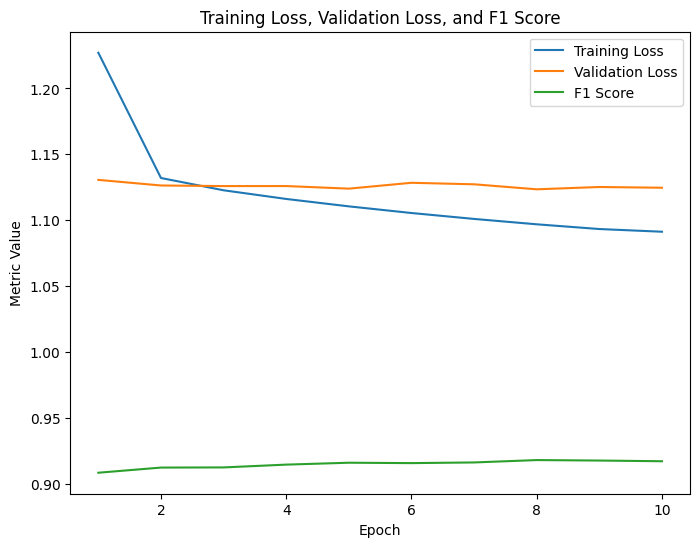

Epoch                 Training Loss       Validation Loss     F1 Score            Accuracy               Precision
--------------------  ------------------  ------------------  ------------------  ------------------  ------------
1                     1.2270389293032617  1.1306759318471409  0.9087749537885146  0.9105343221144704      0.908238
2                     1.1321013820484143  1.126433235610846   0.912673848662495   0.9164765164479939      0.911008
3                     1.1228008572664707  1.1259860002042676  0.9127927513518961  0.9175698802053622      0.911887
4                     1.1162307299979248  1.126003443288259   0.914915628403625   0.9171895797680167      0.913855
5                     1.1106150875626792  1.1240461074354078  0.9163487652079914  0.9192336946187488      0.914805
6                     1.1055772285574463  1.1284774901749064  0.9160547262370208  0.91500285225328        0.917245
7                     1.1010930532984502  1.1273346478041588  0.9165610971667163

In [41]:
train_model(trainer, dataloader_train, dataloader_val, epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0899444419844222
Validation loss: 1.124729866627958
F1 Score (weighted): 0.9174803358831669


Epoch 2:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.0898422170900282
Validation loss: 1.1247298653134827
F1 Score (weighted): 0.9174803358831669
0.01% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.089859766446159
Validation loss: 1.1247298670812251
F1 Score (weighted): 0.9174803358831669
0.0% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.0898757511426245
Validation loss: 1.1247298683503735
F1 Score (weighted): 0.9174803358831669
0.0% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.0897204742739839
Validation loss: 1.124729869256908
F1 Score (weighted): 0.9174803358831669
0.01% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 6
Training loss: 1.0899729143340178
Validation loss: 1.1247298694382148
F1 Score (weighted): 0.9174803358831669
0.02% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 7
Training loss: 1.0901276454195137
Validation loss: 1.1247773908390293
F1 Score (weighted): 0.9174803358831669
0.01% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 8
Training loss: 1.090328895614546
Validation loss: 1.124729866945245
F1 Score (weighted): 0.9174803358831669
0.02% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 9
Training loss: 1.089747254300922
Validation loss: 1.124729873562947
F1 Score (weighted): 0.9174803358831669
0.05% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/9871 [00:00<?, ?it/s]


Epoch 10
Training loss: 1.0899105681291938
Validation loss: 1.1247298650868491
F1 Score (weighted): 0.9174803358831669
0.01% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch

Total training time: 476.7914239048958 minutes
Final Accuracy: 0.9187107815173987
Final Precision: 0.9165138989518093


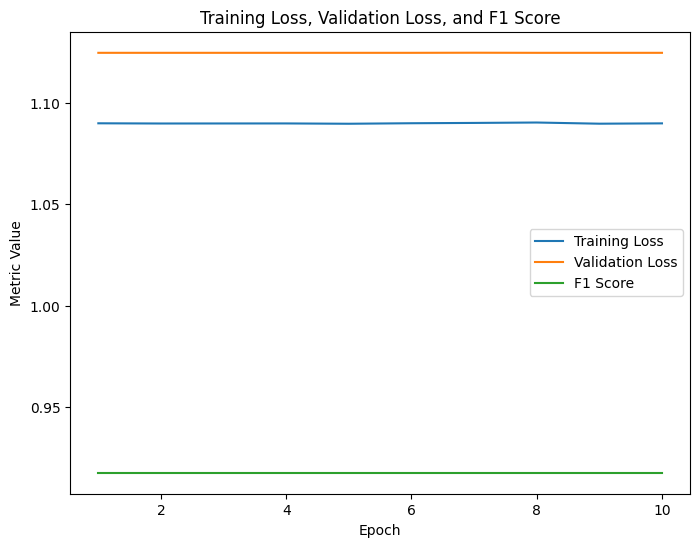

Epoch                 Training Loss       Validation Loss     F1 Score            Accuracy               Precision
--------------------  ------------------  ------------------  ------------------  ------------------  ------------
1                     1.0899444419844222  1.124729866627958   0.9174803358831669  0.9187107815173987      0.916514
2                     1.0898422170900282  1.1247298653134827  0.9174803358831669  0.9187107815173987      0.916514
3                     1.089859766446159   1.1247298670812251  0.9174803358831669  0.9187107815173987      0.916514
4                     1.0898757511426245  1.1247298683503735  0.9174803358831669  0.9187107815173987      0.916514
5                     1.0897204742739839  1.124729869256908   0.9174803358831669  0.9187107815173987      0.916514
6                     1.0899729143340178  1.1247298694382148  0.9174803358831669  0.9187107815173987      0.916514
7                     1.0901276454195137  1.1247773908390293  0.9174803358831669

In [42]:
    total_training_time = 0
    
    training_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    precision_list = []
    f1_score_list = []
    
    previous_results = None  # Store previous epoch results
    
    for epoch in tqdm(range(1, epochs + 1)):
        start_time = time.time()
    
        model.train()
        loss_train_total = 0
    
        progress_bar = tqdm(dataloader_train,
                            desc='Epoch {:1d}'.format(epoch),
                            leave=False,
                            disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }
            output, predictions, true_vals = model(**inputs)
            loss = output
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
        end_time = time.time()
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time
    
        torch.save(model.state_dict(), f'Models/finetuned_bert_lstm_ft_epoch{epoch}.model')
    
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
    
        val_loss, predictions, true_vals = evaluate(dataloader_val)
    
        # Convert predictions to discrete labels
        predictions = np.argmax(predictions, axis=1)
    
        val_f1 = f1_score(true_vals, predictions, average='weighted')
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
    
        val_accuracy = accuracy_score(true_vals, predictions)
        val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)
    
        # Compute and store metrics
        training_loss_list.append(loss_train_avg)
        validation_loss_list.append(val_loss)
        f1_score_list.append(val_f1)
        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
    
        # Check if there are previous results to compare with
        if previous_results is not None:
            if loss_train_avg > previous_results['loss_train_avg']:
                percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
            if loss_train_avg < previous_results['loss_train_avg']:
                percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
            if val_loss > previous_results['val_loss']:
                percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
            if val_loss < previous_results['val_loss']:
                percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
            if val_f1 < previous_results['val_f1']:
                percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
            if val_f1 > previous_results['val_f1']:
                percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')
    
        # Store current results as previous results for the next epoch
        previous_results = {
            'loss_train_avg': loss_train_avg,
            'val_loss': val_loss,
            'val_f1': val_f1
        }
    
    total_time_minutes = total_training_time / 60
    tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')
    
    final_accuracy = accuracy_list[-1]
    final_precision = precision_list[-1]
    tqdm.write(f'Final Accuracy: {final_accuracy}')
    tqdm.write(f'Final Precision: {final_precision}')
    
    # Create a single subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot training loss
    ax.plot(range(1, epochs + 1), training_loss_list, label='Training Loss')
    
    # Plot validation loss
    ax.plot(range(1, epochs + 1), validation_loss_list, label='Validation Loss')
    
    # Plot F1-score
    ax.plot(range(1, epochs + 1), f1_score_list, label='F1 Score')
    
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.set_title('Training Loss, Validation Loss, and F1 Score')
    
    # Set legend
    ax.legend()
    
    # Show the combined plot
    plt.show()

    
    # Create the metrics table
    metrics_table = [
        ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
    ]
    previous_results = None
    for epoch in range(1, epochs + 1):
        row = [
            epoch,
            training_loss_list[epoch - 1],
            validation_loss_list[epoch - 1],
            f1_score_list[epoch - 1],
            accuracy_list[epoch - 1],
            precision_list[epoch - 1]
        ]
    
        # Compare with previous epoch results
        if previous_results is not None:
            if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
                row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
            if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
                row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
            if validation_loss_list[epoch - 1] < previous_results['val_loss']:
                row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
            if validation_loss_list[epoch - 1] > previous_results['val_loss']:
                row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
            if f1_score_list[epoch - 1] > previous_results['val_f1']:
                row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if f1_score_list[epoch - 1] < previous_results['val_f1']:
                row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
    
        metrics_table.append(row)
        previous_results = {
            'loss_train_avg': training_loss_list[epoch - 1],
            'val_loss': validation_loss_list[epoch - 1],
            'val_f1': f1_score_list[epoch - 1]
        }
    
    # Calculate total training time in minutes
    total_time_minutes = total_training_time / 60
    
    # Calculate total precision
    total_precision = precision_list[-1]
    
    # Add total training time and total precision rows to the table
    metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
    metrics_table.append(['Final Precision', '', '', '', '', total_precision])
    metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])
    
    # Print the table
    print(tabulate(metrics_table, headers='firstrow'))